In [79]:
from elasticsearch import Elasticsearch
from collections import Counter
import pandas as pd
import pyupset as pyu

%matplotlib inline

In [2]:
es = Elasticsearch()
es

<Elasticsearch([{}])>

In [4]:
res = es.search(index="g2p", size=10000, body={"query": {"match_all": {}}})

In [5]:
def collect_all_results():
    res = es.search(index="g2p", size=10000, body={"query": {"match_all": {}}}, scroll='1m')
    scroll_id = res.get('_scroll_id')
    i = 1
    while scroll_id is not None:
        print('Processing scroll {}'.format(i))
        r = es.scroll(scroll_id)
        scroll_id = r.get('_scroll_id')
        res['hits']['hits'] += r['hits']['hits']
        i += 1
    return res
        

In [6]:
res = collect_all_results()

Processing scroll 1


# Total Associations

In [7]:
assert len(res['hits']['hits']) == res['hits']['total']
len(res['hits']['hits'])

11634

In [18]:
def count_attribute(result, attribute):
    c = Counter([x['_source'][attribute] for x in result['hits']['hits']])
    return c

def count_attribute_by_group(result, attribute, group):
    d = dict()
    for g in count_attribute(result, group):
        d[g] = Counter([x['_source'][attribute] for x in result['hits']['hits'] if x['_source'][group] == g])
    return d

def count_list_attribute(result, list_attribute):
    c = Counter([attribute for x in result['hits']['hits'] for attribute in x['_source'][list_attribute]])
    return c

def count_list_attribute_by_group(result, list_attribute, group):
    d = dict()
    for g in count_attribute(result, group):
        d[g] = Counter([attribute for x in result['hits']['hits'] for attribute in x['_source'][list_attribute] if x['_source'][group] == g])
    return d

In [9]:
count_attribute(res, 'source')

Counter({'cgi': 1429, 'civic': 2713, 'jax': 6513, 'oncokb': 373, 'pmkb': 606})

# Genes

In [17]:
count_list_attribute(res, 'genes')

Counter({'ABCB1': 5,
         'ABCC10': 1,
         'ABCC3': 1,
         'ABCG2': 1,
         'ABL1': 385,
         'ACTA1': 1,
         'AFF1': 4,
         'AGR2': 1,
         'AHCYL1': 2,
         'AKT1': 66,
         'AKT2': 3,
         'AKT3': 4,
         'ALCAM': 1,
         'ALDH1A2': 3,
         'ALK': 1020,
         'ANXA1': 2,
         'APC': 99,
         'AR': 22,
         'ARAF': 8,
         'AREG': 7,
         'ARID1A': 4,
         'ASNS': 1,
         'ASXL1': 13,
         'ATM': 52,
         'ATR': 4,
         'ATRX': 8,
         'AURKA': 8,
         'AXL': 1,
         'B2M': 2,
         'B4GALT1': 1,
         'BAIAP2L1': 8,
         'BAP1': 12,
         'BCL': 1,
         'BCL2': 4,
         'BCL2L11': 2,
         'BCL6': 1,
         'BCOR': 4,
         'BCORL1': 1,
         'BICC1': 3,
         'BIRC3': 1,
         'BIRC5': 2,
         'BIRC7': 1,
         'BRAF': 1340,
         'BRCA1': 88,
         'BRCA2': 77,
         'BRD4': 1,
         'BTK': 4,
         'C15orf55'

In [51]:
d = count_list_attribute_by_group(res, 'genes', 'source')

CGI has some genotype "genes" (e.g. 'ARID1A;ANXA1' from ARID1A amplification + ANXA1 overexpression)

CKB have some multi-gene molecular profiles. Example: https://ckb.jax.org/molecularProfile/show/26172

In [131]:
multi_gene_hits = [x for x in res['hits']['hits'] if len(x['_source']['genes']) >= 2]
s = Counter([x['_source']['source'] for x in multi_gene_hits])
s

Counter({'cgi': 45, 'jax': 2492})

In [132]:
mp_d = dict()
for source in s:
    mp_d[source] = set([tuple(sorted(x['_source']['genes'])) for x in res['hits']['hits'] if (len(x['_source']['genes']) >= 2) and (x['_source']['source'] == source)])

In [133]:
mp_d

{'cgi': {('ABL1', 'PRKCH'),
  ('ANXA1', 'ARID1A'),
  ('AR', 'AR'),
  ('ATM', 'RAD50'),
  ('BRAF', 'EGFR'),
  ('BRAF', 'MAP2K1'),
  ('BRAF', 'MET'),
  ('BRAF', 'NF1'),
  ('BRAF', 'PTEN'),
  ('BRAF', 'RAC1'),
  ('BRAF', 'RAF1'),
  ('CDK4', 'RB1'),
  ('EGFR', 'MET'),
  ('EGFR', 'NF2'),
  ('ERBB2', 'ESR1'),
  ('ERBB2', 'HGF'),
  ('ERBB2', 'MET'),
  ('ERBB2', 'PIK3CA'),
  ('ERBB2', 'PTEN'),
  ('G6PD', 'G6PD'),
  ('IL7R', 'SH2B3'),
  ('KRAS', 'STK11')},
 'jax': {('AFF1', 'KMT2A'),
  ('AHCYL1', 'FGFR2'),
  ('AKT1', 'BRAF', 'KRAS'),
  ('AKT1', 'BRAF', 'PTEN'),
  ('AKT1', 'FGFR3'),
  ('AKT1', 'NRAS'),
  ('AKT1', 'PIK3CA'),
  ('ALK', 'EML4'),
  ('ALK', 'EML4', 'SRC'),
  ('ALK', 'ETV6'),
  ('ALK', 'MAP2K1'),
  ('ALK', 'NPM1'),
  ('ALK', 'RB1', 'TP53'),
  ('ALK', 'ROS1'),
  ('ALK', 'SRC'),
  ('ALK', 'TP53'),
  ('APC', 'BRAF', 'ERBB2'),
  ('APC', 'BRAF', 'PIK3CA', 'SMAD4', 'TP53'),
  ('APC', 'CTNNB1'),
  ('APC', 'KDR', 'KRAS'),
  ('APC', 'KRAS'),
  ('APC', 'KRAS', 'PTEN'),
  ('APC', 'PTEN'),
  ('AS

In [134]:
{}

Counter({'cgi': 45, 'jax': 2492})

In [49]:
def overlap(group_counts):
    columns = sorted(group_counts) + ['Total']
    sets = {g: set(group_counts[g]) for g in group_counts}
    for g in sets:
        total = set()
        for s in sets:
            l = len(sets[g])
            if s != g:
                o = (sets[g] & sets[s])
                total |= sets[s]
            else:
                continue
            print('{} has {}/{} ({:.2f}%) overlap with {}'.format(g, len(o), l, len(o) / l * 100, s))
        o = (sets[g] & total)
        print('{} has {}/{} ({:.2f}%) overlap overall'.format(g, len(o), l, len(o) / l * 100, s))

In [52]:
overlap(d)

cgi has 59/181 (32.60%) overlap with jax
cgi has 121/181 (66.85%) overlap with civic
cgi has 42/181 (23.20%) overlap with oncokb
cgi has 37/181 (20.44%) overlap with pmkb
cgi has 126/181 (69.61%) overlap overall
jax has 59/106 (55.66%) overlap with cgi
jax has 73/106 (68.87%) overlap with civic
jax has 30/106 (28.30%) overlap with oncokb
jax has 37/106 (34.91%) overlap with pmkb
jax has 78/106 (73.58%) overlap overall
civic has 121/290 (41.72%) overlap with cgi
civic has 73/290 (25.17%) overlap with jax
civic has 42/290 (14.48%) overlap with oncokb
civic has 38/290 (13.10%) overlap with pmkb
civic has 139/290 (47.93%) overlap overall
oncokb has 42/43 (97.67%) overlap with cgi
oncokb has 30/43 (69.77%) overlap with jax
oncokb has 42/43 (97.67%) overlap with civic
oncokb has 20/43 (46.51%) overlap with pmkb
oncokb has 43/43 (100.00%) overlap overall
pmkb has 37/42 (88.10%) overlap with cgi
pmkb has 37/42 (88.10%) overlap with jax
pmkb has 38/42 (90.48%) overlap with civic
pmkb has 20/42 

In [96]:
def plot_overlap(d):
    d2 = {g: pd.DataFrame(list(d[g].keys()), columns=['attribute']) for g in d}
    pyu.plot(d2, unique_keys = ['attribute'])

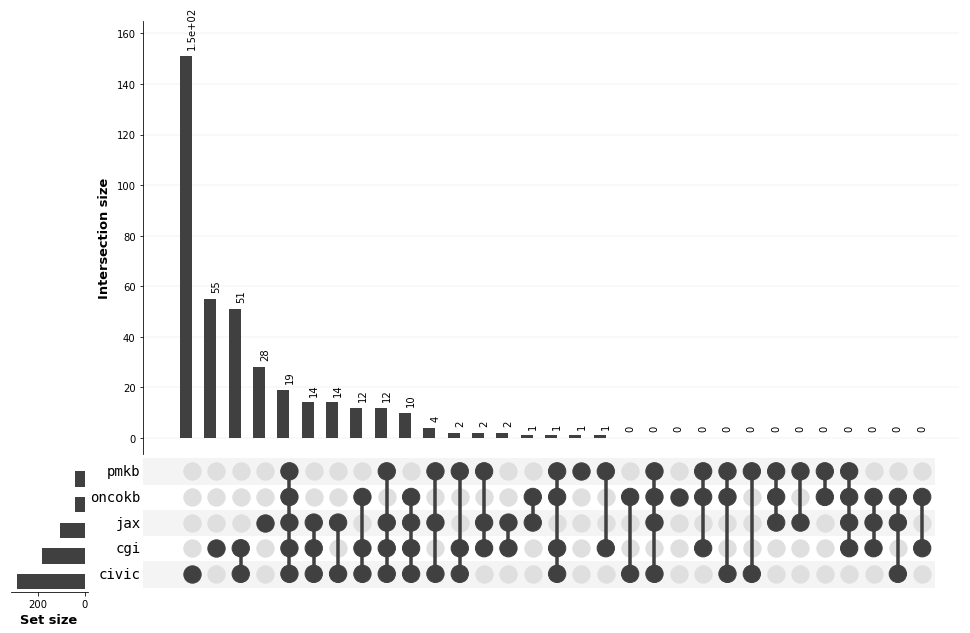

In [97]:
plot_overlap(d)

# Overlap of evidence associations (drug + gene + phenotype)

Some hits (example here is from CGI) have strange behavior on drug normalization:

In [115]:
res['hits']['hits'][0]['_source']['association']['environmentalContexts']

[{'description': 'Imatinib',
  'id': 'compound:CID5291',
  'term': 'Imatinib',
  'toxicity': 'The most frequently reported adverse reactions (>30%) were edema, nausea,\r\nvomiting, muscle cramps, musculoskeletal pain, diarrhea, rash, fatigue and\r\nabdominal pain.'},
 {'description': 'inhibitor',
  'id': 'compound:CID657356',
  'term': 'inhibitor',
  'toxicity': 'unknown'},
 {'description': 'Clorazepate Dipotassium',
  'id': 'compound:CID23706210',
  'term': 'Clorazepate Dipotassium',
  'toxicity': 'unknown'}]

In [116]:
res['hits']['hits'][0]['_source']['cgi']

{'Alteration': 'ABL1:I242T,M244V,K247R,L248V,G250E,G250R,Q252R,Q252H,Y253F,Y253H,E255K,E255V,M237V,E258D,W261L,L273M,E275K,E275Q,D276G,T277A,E279K,V280A,V289A,V289I,E292V,E292Q,I293V,L298V,V299L,F311L,F311I,T315I,F317L,F317V,F317I,F317C,Y320C,L324Q,Y342H,M343T,A344V,A350V,M351T,E355D,E355G,E355A,F359V,F359I,F359C,F359L,D363Y,L364I,A365V,A366G,L370P,V371A,E373K,V379I,A380T,F382L,L384M,L387M,L387F,L387V,M388L,Y393C,H396P,H396R,H396A,A397P,S417F,S417Y,I418S,I418V,A433T,S438C,E450K,E450G,E450A,E450V,E453K,E453G,E453A,E453V,E459K,E459G,E459A,E459V,M472I,P480L,F486S,E507G',
 'Alteration type': 'MUT',
 'Assay type': '',
 'Association': 'Resistant',
 'Biomarker': 'ABL1 (I242T,M244V,K247R,L248V,G250E,G250R,Q252R,Q252H,Y253F,Y253H,E255K,E255V,M237V,E258D,W261L,L273M,E275K,E275Q,D276G,T277A,E279K,V280A,V289A,V289I,E292V,E292Q,I293V,L298V,V299L,F311L,F311I,T315I,F317L,F317V,F317I,F317C,Y320C,L324Q,Y342H,M343T,A344V,A350V,M351T,E355D,E355G,E355A,F359V,F359I,F359C,F359L,D363Y,L364I,A365V,A366G,L370P

In [ ]:
def merge_hits(hits):
    merged = []
    for hit in hits:
        gene = sorted(hit['_source']['genes']).join('|')
        drug = sorted([x['id'] for x in hit['_source']['association']['environmentalContexts']]).join('|')
        